In [1]:
library(TSA)
library(mgcv)
library(MASS)
library(data.table)
library(vars)


Attaching package: 'TSA'

The following objects are masked from 'package:stats':

    acf, arima

The following object is masked from 'package:utils':

    tar

Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.
Loading required package: strucchange
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: urca
Loading required package: lmtest


In [2]:
data.raw = read.csv("Currency Conversion Data.csv", header=TRUE)
head(data.raw, n=5)
tail(data.raw, n=5)
data.raw=ts(data.raw, start=c(2014,7), frequency=52)


,DATE,USD.EU,USD.GBP,USD.AUD,USD.NZ
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,7/2/2014,1.36536,1.709020,0.943540,0.87654
2,7/9/2014,1.36145,1.713425,0.938125,0.87810
3,7/16/2014,1.35842,1.711780,0.937800,0.87798
4,7/23/2014,1.35002,1.706680,0.939460,0.86816
5,7/30/2014,1.34254,1.695720,0.938520,0.85302


,DATE,USD.EU,USD.GBP,USD.AUD,USD.NZ
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
262,7/3/2019,1.13258,1.263780,0.699900,0.669360
263,7/10/2019,1.12235,1.249475,0.695675,0.662525
264,7/17/2019,1.12438,1.249420,0.701320,0.670400
265,7/24/2019,1.11918,1.248320,0.702080,0.674440
266,7/31/2019,1.11394,1.229240,0.690600,0.662780


In [3]:
par(mfrow=c(2,3))

data=data.raw[1:(nrow(data.raw)-8),]
test=data.raw[(nrow(data.raw)-7):nrow(data.raw),]

head(data, n=5)
test

DATE,USD.EU,USD.GBP,USD.AUD,USD.NZ
206,1.36536,1.709020,0.943540,0.87654
222,1.36145,1.713425,0.938125,0.87810
202,1.35842,1.711780,0.937800,0.87798
209,1.35002,1.706680,0.939460,0.86816
216,1.34254,1.695720,0.938520,0.85302


DATE,USD.EU,USD.GBP,USD.AUD,USD.NZ
177,1.13110,1.271080,0.696960,0.661580
182,1.12274,1.260380,0.687680,0.652480
187,1.13562,1.270980,0.695320,0.662460
215,1.13258,1.263780,0.699900,0.669360
197,1.12235,1.249475,0.695675,0.662525
203,1.12438,1.249420,0.701320,0.670400
210,1.11918,1.248320,0.702080,0.674440
217,1.11394,1.229240,0.690600,0.662780


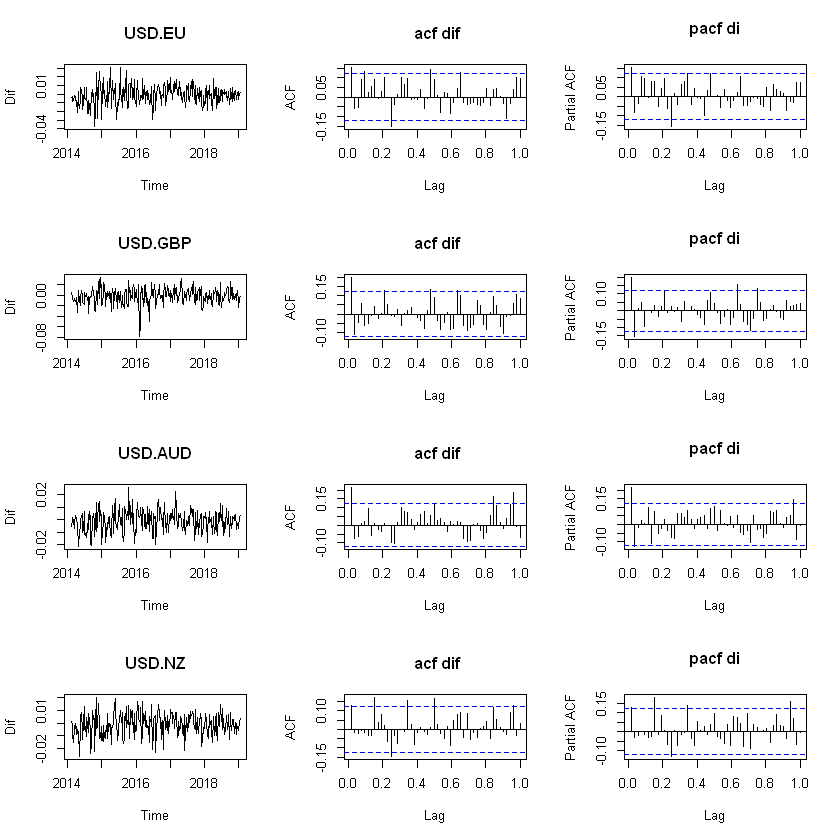

In [4]:
data.dif=ts(diff(data[,-1]), start=c(2014,7), frequency=52)

par(mfrow=c(4,3))
for (i in 1:4){
plot(data.dif[,i], main=colnames(data.dif)[i], type="l", ylab="Dif")
acf(data.dif[,i], main=" acf dif", lag.max=52)
pacf(data.dif[,i], main="pacf di", lag.max=52)    
}


In [5]:
## Order selection -- EACF

for (i in 1:4){
 print(colnames(data.dif)[i])
    eacf(data.dif[,i],ar.max = 7, ma.max = 7)    
    
}


[1] "USD.EU"
AR/MA
  0 1 2 3 4 5 6 7
0 x o o o x o o o
1 x o o o o o o o
2 x x o o x o o o
3 x x x o o o o o
4 x x x x o o o o
5 o x x x o o o o
6 o x x o o o o o
7 x x x o o o o o
[1] "USD.GBP"
AR/MA
  0 1 2 3 4 5 6 7
0 x o o o o o o o
1 x x o o o o o o
2 o x o o o o o o
3 x o x o o o o o
4 x x x o x o o o
5 o x x x o o o o
6 x o o o o x o o
7 x x o o o x o o
[1] "USD.AUD"
AR/MA
  0 1 2 3 4 5 6 7
0 x o o o o o o o
1 x x o o o o o o
2 o x o o o o o o
3 x x o o o o o o
4 x x o x o o o o
5 o x x x o o o o
6 x x o x o x o o
7 x o o x x o o o
[1] "USD.NZ"
AR/MA
  0 1 2 3 4 5 6 7
0 x o o o o o o x
1 x o o o o o o x
2 x o o o o o o x
3 o x o o o o o x
4 o o x o o o o o
5 x x o o o o o o
6 x o o o o o o o
7 x x o o x x x o


In [6]:
## Order selection -- AIC

test_modelA <- function(p,d,q){
 mod = arima(data[,2], order=c(p,d,q), method="ML")
 current.aic = AIC(mod)
 df = data.frame(p,d,q,current.aic)
 names(df) <- c("p","d","q","AIC")
 print(paste(p,d,q,current.aic,sep=" "))
    
 return(df)
 }
 
 orders = data.frame(Inf,Inf,Inf,Inf)
 names(orders) <- c("p","d","q","AIC")
 
 
 for (p in 0:5){
   for (d in 0:1){
     for (q in 0:5) {
       possibleError <- tryCatch(
         orders<-rbind(orders,test_modelA(p,d,q)),
         error=function(e) e
       )
       if(inherits(possibleError, "error")) next
 
     }
   }
 }
 orders <- orders[order(-orders$AIC),]
 tail(orders)
print(colnames(data)[2])

[1] "0 0 0 -667.907186624859"
[1] "0 0 1 -965.020228901173"
[1] "0 0 2 -1166.94962687624"
[1] "0 0 3 -1307.51450667435"
[1] "0 0 4 -1350.96966029842"
[1] "0 0 5 -1407.56888935529"
[1] "0 1 0 -1585.88895547573"
[1] "0 1 1 -1591.31848875027"
[1] "0 1 2 -1589.49861468133"
[1] "0 1 3 -1588.56349192871"
[1] "0 1 4 -1587.26880902788"
[1] "0 1 5 -1591.33234256355"
[1] "1 0 0 -1583.99000027371"
[1] "1 0 1 -1589.76392542343"
[1] "1 0 2 -1587.86331683473"
[1] "1 0 3 -1590.24433939132"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "1 0 4 -1584.62651702513"
[1] "1 0 5 -1578.71322998923"
[1] "1 1 0 -1590.53007899432"
[1] "1 1 1 -1589.41792144268"
[1] "1 1 2 -1587.63186234235"
[1] "1 1 3 -1586.70459237841"
[1] "1 1 4 -1590.58112337327"
[1] "1 1 5 -1590.481319555"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] "2 0 0 -1589.01607137053"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "2 0 1 -1587.81398114834"
[1] "2 0 2 -1562.87958355035"
[1] "2 0 3 -1582.23643011977"
[1] "2 0 4 -1581.07790089763"


Warning message in log(s2):
"NaNs produced"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "2 0 5 -1589.1573897905"
[1] "2 1 0 -1590.03130289968"
[1] "2 1 1 -1588.07993701488"
[1] "2 1 2 -1597.5778939598"
[1] "2 1 3 -1596.07487874517"
[1] "2 1 4 -1590.05807424571"
[1] "2 1 5 -1589.00713614334"
[1] "3 0 0 -1588.32237120979"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 1 -1585.77299238515"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 2 -1595.80545429228"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 3 -1594.25396124766"
[1] "3 0 4 -1584.42669088944"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 5 -1591.02616132846"
[1] "3 1 0 -1588.23056012765"
[1] "3 1 1 -1586.68497286137"
[1] "3 1 2 -1596.04921186624"
[1] "3 1 3 -1596.82331479248"
[1] "3 1 4 -1594.82630535245"
[1] "3 1 5 -1595.13353147381"
[1] "4 0 0 -1586.47097623543"
[1] "4 0 1 -1585.42663541594"
[1] "4 0 2 -1583.41287590811"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 0 3 -1593.19012019566"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 0 4 -1574.46877969434"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 0 5 -1592.33526264643"
[1] "4 1 0 -1589.34814478481"
[1] "4 1 1 -1591.01047923785"
[1] "4 1 2 -1589.01416049708"
[1] "4 1 3 -1587.461905832"
[1] "4 1 4 -1593.1122948953"
[1] "4 1 5 -1595.65673150136"
[1] "5 0 0 -1587.84675736071"
[1] "5 0 1 -1583.43203638994"
[1] "5 0 2 -1593.00563308834"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 0 3 -1591.26425069355"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 0 4 -1589.03566948215"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 0 5 -1588.83638296213"
[1] "5 1 0 -1589.91629503787"
[1] "5 1 1 -1587.91782570337"
[1] "5 1 2 -1587.2360885225"
[1] "5 1 3 -1595.19587050724"
[1] "5 1 4 -1595.5478202137"
[1] "5 1 5 -1595.92221828407"


,p,d,q,AIC
,<dbl>,<dbl>,<dbl>,<dbl>
40,3,0,2,-1595.805
73,5,1,5,-1595.922
46,3,1,2,-1596.049
35,2,1,3,-1596.075
47,3,1,3,-1596.823
34,2,1,2,-1597.578


[1] "USD.EU"


In [7]:
## Order selection -- AIC

test_modelA <- function(p,d,q){
 mod = arima(data[,3], order=c(p,d,q), method="ML")
 current.aic = AIC(mod)
 df = data.frame(p,d,q,current.aic)
 names(df) <- c("p","d","q","AIC")
 print(paste(p,d,q,current.aic,sep=" "))
    
 return(df)
 }
 
 orders = data.frame(Inf,Inf,Inf,Inf)
 names(orders) <- c("p","d","q","AIC")
 
 
 for (p in 0:5){
   for (d in 0:1){
     for (q in 0:5) {
       possibleError <- tryCatch(
         orders<-rbind(orders,test_modelA(p,d,q)),
         error=function(e) e
       )
       if(inherits(possibleError, "error")) next
 
     }
   }
 }
 orders <- orders[order(-orders$AIC),]
 tail(orders)
print(colnames(data)[3])

[1] "0 0 0 -330.301720322643"
[1] "0 0 1 -650.076776990763"
[1] "0 0 2 -893.160930747565"
[1] "0 0 3 -1032.92784668572"
[1] "0 0 4 -1130.19864791137"
[1] "0 0 5 -1193.09528310091"
[1] "0 1 0 -1433.70198442377"
[1] "0 1 1 -1446.50226421002"
[1] "0 1 2 -1445.55302814691"
[1] "0 1 3 -1445.18442233315"
[1] "0 1 4 -1444.76997716519"
[1] "0 1 5 -1443.21758522843"
[1] "1 0 0 -1430.3568403839"
[1] "1 0 1 -1443.46458094139"
[1] "1 0 2 -1442.39255408849"
[1] "1 0 3 -1440.49351435283"
[1] "1 0 4 -1438.87212276841"
[1] "1 0 5 -1432.82491475648"
[1] "1 1 0 -1443.1765144326"
[1] "1 1 1 -1445.13588532426"
[1] "1 1 2 -1444.025687351"
[1] "1 1 3 -1445.03742664363"
[1] "1 1 4 -1443.25781343478"
[1] "1 1 5 -1441.23746295156"
[1] "2 0 0 -1440.15729834173"
[1] "2 0 1 -1441.99774707315"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] "2 0 2 -1445.20505830881"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] "2 0 3 -1444.09174758553"
[1] "2 0 4 -1442.6806452484"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "2 0 5 -1438.06141840881"
[1] "2 1 0 -1446.66976705289"
[1] "2 1 1 -1444.74438429653"
[1] "2 1 2 -1444.85347711051"
[1] "2 1 3 -1443.21861897562"
[1] "2 1 4 -1441.25234127713"
[1] "2 1 5 -1439.24795087742"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 1 -1441.31390077414"
[1] "3 0 2 -1441.70693606049"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] "3 0 3 -1440.00791947151"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] "3 0 5 -1425.45784607734"
[1] "3 1 0 -1444.81182290483"
[1] "3 1 1 -1442.93597408179"
[1] "3 1 2 -1443.93996559177"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 1 3 -1442.72818405331"
[1] "3 1 4 -1439.23263323571"
[1] "3 1 5 -1444.21588059596"
[1] "4 0 0 -1441.59064899539"
[1] "4 0 1 -1439.9940869594"
[1] "4 0 2 -1440.02360447202"
[1] "4 1 0 -1443.67914760522"
[1] "4 1 1 -1443.05371295972"
[1] "4 1 2 -1441.27845006902"
[1] "4 1 3 -1439.24891960863"
[1] "4 1 4 -1437.25043941691"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 1 5 -1439.10544807646"
[1] "5 0 0 -1440.52599551432"
[1] "5 0 1 -1439.88962318389"
[1] "5 0 2 -1438.55100066543"
[1] "5 0 3 -1439.98993542231"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 0 4 -1436.61006643388"
[1] "5 1 0 -1443.48141056784"
[1] "5 1 1 -1441.50727032089"
[1] "5 1 2 -1439.54735707939"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 1 3 -1440.45038159771"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 1 4 -1439.26051115593"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 1 5 -1437.02506069357"


,p,d,q,AIC
,<dbl>,<dbl>,<dbl>,<dbl>
21,1,1,1,-1445.136
11,0,1,3,-1445.184
28,2,0,2,-1445.205
10,0,1,2,-1445.553
9,0,1,1,-1446.502
32,2,1,0,-1446.670


[1] "USD.GBP"


In [8]:
## Order selection -- AIC

test_modelA <- function(p,d,q){
 mod = arima(data[,4], order=c(p,d,q), method="ML")
 current.aic = AIC(mod)
 df = data.frame(p,d,q,current.aic)
 names(df) <- c("p","d","q","AIC")
 print(paste(p,d,q,current.aic,sep=" "))
    
 return(df)
 }
 
 orders = data.frame(Inf,Inf,Inf,Inf)
 names(orders) <- c("p","d","q","AIC")
 
 
 for (p in 0:5){
   for (d in 0:1){
     for (q in 0:5) {
       possibleError <- tryCatch(
         orders<-rbind(orders,test_modelA(p,d,q)),
         error=function(e) e
       )
       if(inherits(possibleError, "error")) next
 
     }
   }
 }
 orders <- orders[order(-orders$AIC),]
 tail(orders)
print(colnames(data)[4])

[1] "0 0 0 -776.186440159815"
[1] "0 0 1 -1077.36656608779"
[1] "0 0 2 -1314.73906038303"
[1] "0 0 3 -1412.49666355877"
[1] "0 0 4 -1519.21158367723"
[1] "0 0 5 -1550.97922267678"
[1] "0 1 0 -1735.38204813289"
[1] "0 1 1 -1749.48093888563"
[1] "0 1 2 -1747.75821165781"
[1] "0 1 3 -1746.75786813242"
[1] "0 1 4 -1745.34259729591"
[1] "0 1 5 -1743.93542349334"
[1] "1 0 0 -1733.24462448565"
[1] "1 0 1 -1747.69958949002"
[1] "1 0 2 -1745.90989894083"
[1] "1 0 3 -1749.40889296077"
[1] "1 0 4 -1742.08024024104"
[1] "1 0 5 -1740.96843345904"
[1] "1 1 0 -1746.89346427009"
[1] "1 1 1 -1747.66172552659"
[1] "1 1 2 -1746.0595877755"
[1] "1 1 3 -1748.93925770485"
[1] "1 1 4 -1747.28500880066"
[1] "1 1 5 -1745.85410459788"


Warning message in log(s2):
"NaNs produced"

[1] "2 0 1 -1745.73328691827"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "2 0 2 -1745.89913677972"
[1] "2 0 3 -1743.3887360083"
[1] "2 0 4 -1742.32838987444"
[1] "2 0 5 -1742.61567096958"
[1] "2 1 0 -1748.58079054399"
[1] "2 1 1 -1746.58386187862"
[1] "2 1 2 -1744.67576248667"
[1] "2 1 3 -1747.96161650338"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "2 1 4 -1746.73269845991"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "2 1 5 -1744.78171227688"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 0 -1651.33990418417"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 1 -1742.0823579662"
[1] "3 0 2 -1748.00106774097"
[1] "3 0 3 -1740.54508285114"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 4 -1742.52389991277"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 5 -1747.47801079069"
[1] "3 1 0 -1746.58561998364"
[1] "3 1 1 -1744.59960815475"
[1] "3 1 2 -1742.67544983684"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 1 3 -1747.14070134522"
[1] "3 1 4 -1743.20503030348"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 1 5 -1743.1719923114"
[1] "4 0 0 -1744.61626076831"
[1] "4 0 1 -1744.62947226692"
[1] "4 0 2 -1751.55478587427"
[1] "4 0 3 -1749.81431161019"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 0 4 -1741.89787362796"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 0 5 -1742.00746156697"
[1] "4 1 0 -1744.84889406572"
[1] "4 1 1 -1745.32079922821"
[1] "4 1 2 -1743.41704256553"
[1] "4 1 3 -1750.18248722683"


Warning message in log(s2):
"NaNs produced"

[1] "4 1 4 -1745.66287230022"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 1 5 -1743.98214983119"
[1] "5 0 0 -1742.95039192455"
[1] "5 0 1 -1743.42318473484"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] "5 0 2 -1745.17484198521"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 0 3 -1742.11048386138"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 0 4 -1736.77052347462"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 0 5 -1745.23910487189"
[1] "5 1 0 -1742.89832659015"
[1] "5 1 1 -1740.85020703726"
[1] "5 1 2 -1742.88662449752"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "5 1 3 -1743.48701051638"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] "5 1 4 -1748.94399911496"
[1] "5 1 5 -1748.16253875314"


,p,d,q,AIC
,<dbl>,<dbl>,<dbl>,<dbl>
71,5,1,4,-1748.944
17,1,0,3,-1749.409
9,0,1,1,-1749.481
52,4,0,3,-1749.814
58,4,1,3,-1750.182
51,4,0,2,-1751.555


[1] "USD.AUD"


In [9]:
## Order selection -- AIC

test_modelA <- function(p,d,q){
 mod = arima(data[,5], order=c(p,d,q), method="ML")
 current.aic = AIC(mod)
 df = data.frame(p,d,q,current.aic)
 names(df) <- c("p","d","q","AIC")
 print(paste(p,d,q,current.aic,sep=" "))
    
 return(df)
 }
 
 orders = data.frame(Inf,Inf,Inf,Inf)
 names(orders) <- c("p","d","q","AIC")
 
 
 for (p in 0:5){
   for (d in 0:1){
     for (q in 0:5) {
       possibleError <- tryCatch(
         orders<-rbind(orders,test_modelA(p,d,q)),
         error=function(e) e
       )
       if(inherits(possibleError, "error")) next
 
     }
   }
 }
 orders <- orders[order(-orders$AIC),]
 tail(orders)
print(colnames(data)[5])

[1] "0 0 0 -835.100712481775"
[1] "0 0 1 -1121.34493561546"
[1] "0 0 2 -1318.45442171017"
[1] "0 0 3 -1438.98623890577"
[1] "0 0 4 -1502.04777043548"
[1] "0 0 5 -1539.88035096144"
[1] "0 1 0 -1711.67777789182"
[1] "0 1 1 -1714.68023704525"
[1] "0 1 2 -1712.68026835221"
[1] "0 1 3 -1710.74141082174"
[1] "0 1 4 -1708.74146668238"
[1] "0 1 5 -1706.74320469619"
[1] "1 0 0 -1710.03918795973"
[1] "1 0 1 -1713.34776829947"
[1] "1 0 2 -1711.35543420473"
[1] "1 0 3 -1704.83727020721"
[1] "1 0 4 -1696.98682944133"
[1] "1 0 5 -1695.22299576051"
[1] "1 1 0 -1714.56483536174"
[1] "1 1 1 -1712.67705042529"
[1] "1 1 2 -1710.6803692635"
[1] "1 1 3 -1708.74066001924"
[1] "1 1 4 -1706.74149361556"
[1] "1 1 5 -1704.74219833511"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] "2 0 0 -1713.28690338592"
[1] "2 0 1 -1711.35370211817"
[1] "2 0 2 -1715.0456486771"
[1] "2 0 3 -1713.39422578541"
[1] "2 0 4 -1711.5835102947"
[1] "2 0 5 -1701.05403315226"
[1] "2 1 0 -1712.70224987256"
[1] "2 1 1 -1710.69247101884"
[1] "2 1 2 -1708.74310843232"
[1] "2 1 3 -1706.74066465139"
[1] "2 1 4 -1704.74151379266"
[1] "2 1 5 -1702.74224149543"
[1] "3 0 0 -1711.36538985442"
[1] "3 0 1 -1714.3781105992"
[1] "3 0 2 -1713.64518210451"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 3 -1708.7627192545"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 4 -1709.92181508448"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "3 0 5 -1705.79905136643"
[1] "3 1 0 -1710.73223982841"
[1] "3 1 1 -1708.73467142881"
[1] "3 1 2 -1706.73429262947"
[1] "3 1 3 -1704.74259581007"
[1] "3 1 4 -1702.74080955939"
[1] "3 1 5 -1700.7406928594"
[1] "4 0 0 -1709.37081641311"
[1] "4 0 1 -1713.09078011263"
[1] "4 0 2 -1705.36340899276"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 0 3 -1711.55089987359"


Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 0 4 -1709.5826469392"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 0 5 -1705.13609747765"
[1] "4 1 0 -1708.74162436597"
[1] "4 1 1 -1706.74302532579"
[1] "4 1 2 -1704.74278161482"
[1] "4 1 3 -1702.74291339861"
[1] "4 1 4 -1700.741474583"


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

[1] "4 1 5 -1705.88783864769"
[1] "5 0 0 -1707.40393019515"
[1] "5 0 1 -1711.35827065122"
[1] "5 0 2 -1711.27580960181"
[1] "5 0 3 -1711.841942915"
[1] "5 0 4 -1709.60313781221"
[1] "5 0 5 -1708.67380448224"
[1] "5 1 0 -1706.75798709872"
[1] "5 1 1 -1704.7520883296"
[1] "5 1 2 -1702.75300799946"
[1] "5 1 3 -1718.09804300049"
[1] "5 1 4 -1710.0509400387"
[1] "5 1 5 -1718.63142133643"


,p,d,q,AIC
,<dbl>,<dbl>,<dbl>,<dbl>
39,3,0,1,-1714.378
20,1,1,0,-1714.565
9,0,1,1,-1714.680
28,2,0,2,-1715.046
71,5,1,3,-1718.098
73,5,1,5,-1718.631


[1] "USD.NZ"


In [10]:
mod.EUR = arima(data[,2], order = c(2,1,3), method = "ML") 
mod.GBP = arima(data[,3], order = c(1,1,1), method = "ML") 
mod.AUD = arima(data[,4], order = c(1,0,3), method = "ML") 
mod.NZD = arima(data[,5], order = c(2,0,2), method = "ML") 

mod.EUR 
mod.GBP 
mod.AUD 
mod.NZD 


Call:
arima(x = data[, 2], order = c(2, 1, 3), method = "ML")

Coefficients:
          ar1      ar2     ma1     ma2     ma3
      -0.4442  -0.8627  0.6287  0.9667  0.0530
s.e.   0.0848   0.0675  0.1077  0.0714  0.0753

sigma^2 estimated as 0.0001119:  log likelihood = 804.04,  aic = -1598.07


Call:
arima(x = data[, 3], order = c(1, 1, 1), method = "ML")

Coefficients:
          ar1     ma1
      -0.1384  0.3844
s.e.   0.1723  0.1553

sigma^2 estimated as 0.0002066:  log likelihood = 725.57,  aic = -1447.14

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Call:
arima(x = data[, 4], order = c(1, 0, 3), method = "ML")

Coefficients:
      ar1     ma1      ma2      ma3  intercept
        1  0.2516  -0.0467  -0.0318     0.7682
s.e.  NaN  0.0630   0.0621   0.0556     1.2314

sigma^2 estimated as 6.32e-05:  log likelihood = 880.7,  aic = -1751.41


Call:
arima(x = data[, 5], order = c(2, 0, 2), method = "ML")

Coefficients:
          ar1     ar2     ma1     ma2  intercept
      -0.0057  0.9876  1.1757  0.1889     0.7259
s.e.   0.0117  0.0113  0.0653  0.0646     0.0504

sigma^2 estimated as 7.113e-05:  log likelihood = 863.52,  aic = -1717.05

In [11]:
nrow(data)

[1] 258

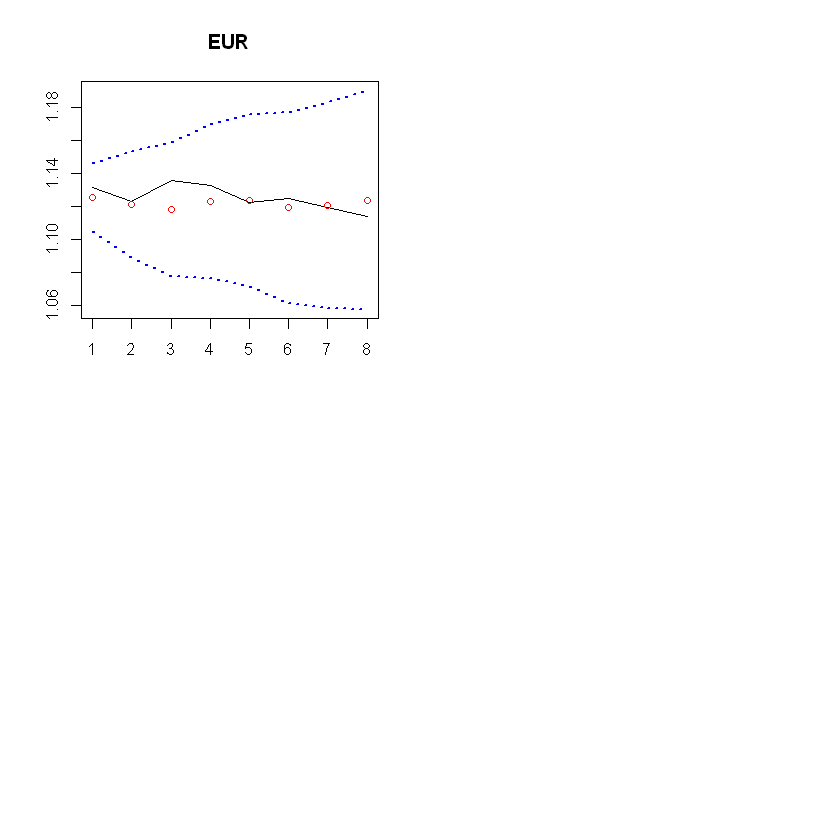

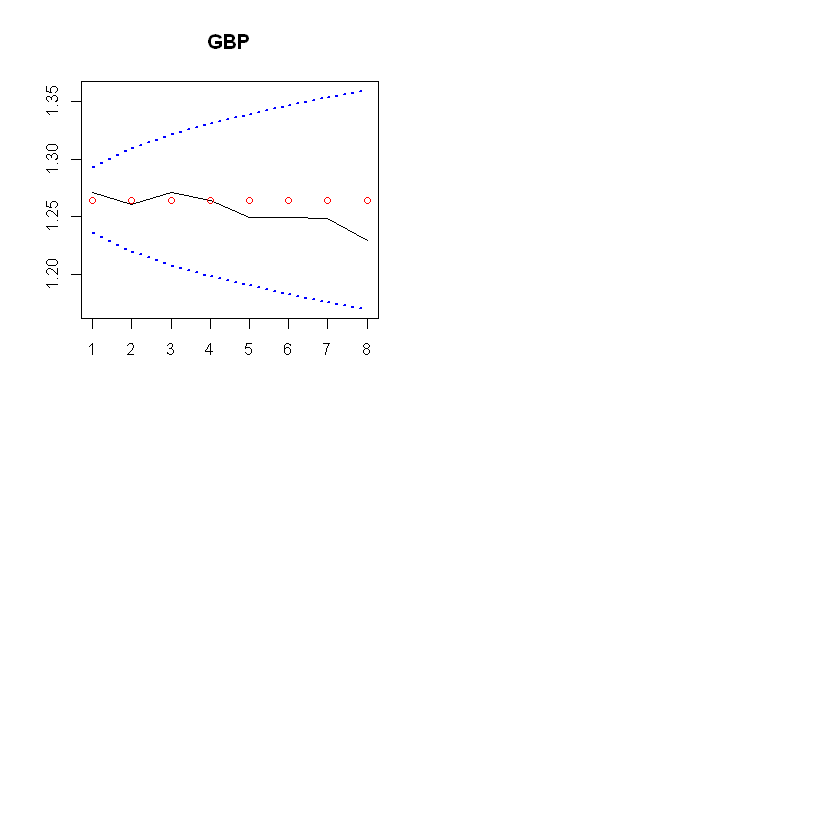

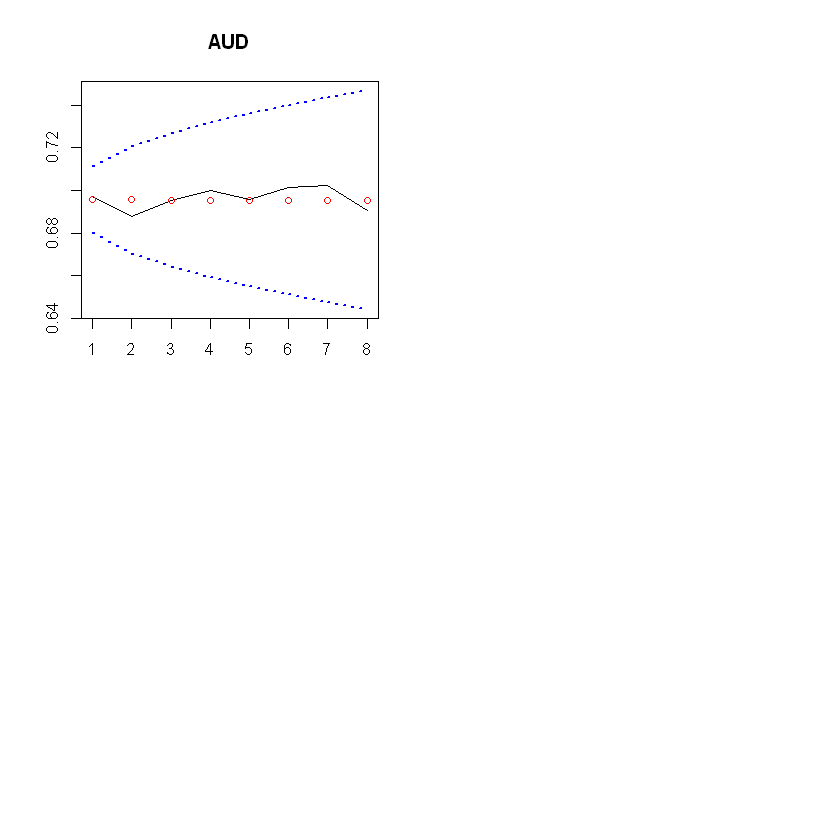

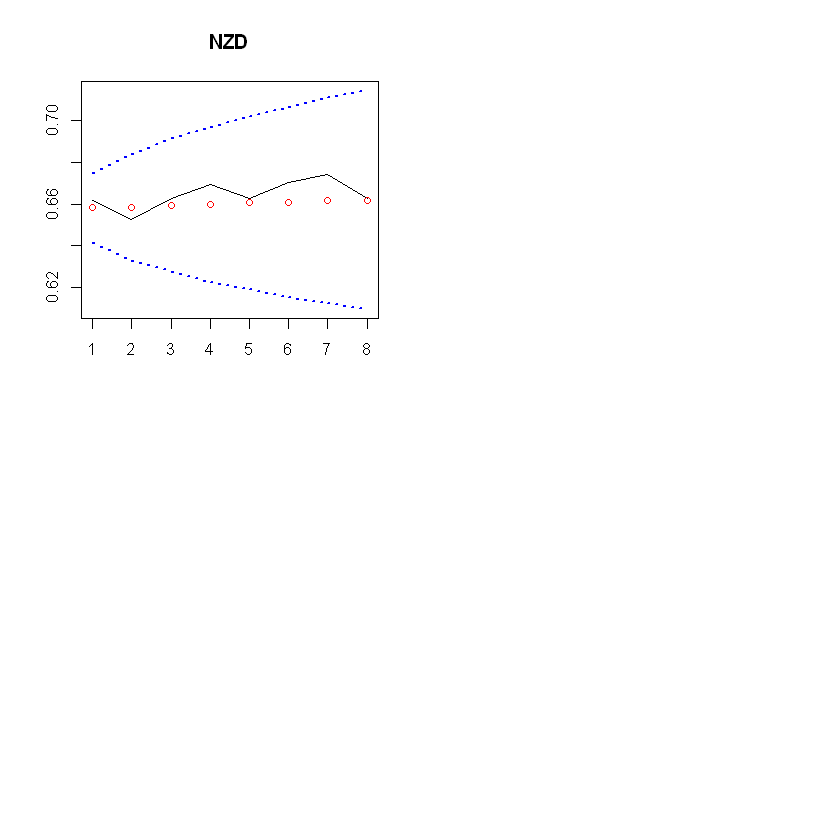

In [12]:
mod.EUR.pred = predict(mod.EUR,n.ahead=8) 

ubound = mod.EUR.pred$pred+1.96*mod.EUR.pred$se 
lbound = mod.EUR.pred$pred-1.96*mod.EUR.pred$se 

ymin = min(lbound) 
ymax = max(ubound) 

par(mfrow=c(2,2))


par(mfrow=c(2,2))
plot(1:8,test[,2], type="l", ylim=c(ymin,ymax), xlab="", ylab="", main="EUR") 
points(1:8,mod.EUR.pred$pred,col="red") 
lines(1:8, ubound,lty=3,lwd= 2, col="blue")
lines(1:8, lbound,lty=3,lwd= 2, col="blue")


#########################################GBP########################################

mod.GBP.pred = predict(mod.GBP,n.ahead=8) 

ubound = mod.GBP.pred$pred+1.96*mod.GBP.pred$se 
lbound = mod.GBP.pred$pred-1.96*mod.GBP.pred$se 

ymin = min(lbound) 
ymax = max(ubound) 

par(mfrow=c(2,2))


par(mfrow=c(2,2))
plot(1:8,test[,3], type="l", ylim=c(ymin,ymax), xlab="", ylab="", main="GBP") 
points(1:8,mod.GBP.pred$pred,col="red") 
lines(1:8, ubound,lty=3,lwd= 2, col="blue")
lines(1:8, lbound,lty=3,lwd= 2, col="blue")



#####################################AUD#############################################


mod.AUD.pred = predict(mod.AUD,n.ahead=8) 

ubound = mod.AUD.pred$pred+1.96*mod.AUD.pred$se 
lbound = mod.AUD.pred$pred-1.96*mod.AUD.pred$se 

ymin = min(lbound) 
ymax = max(ubound) 

par(mfrow=c(2,2))


par(mfrow=c(2,2))
plot(1:8, test[,4], type="l", ylim=c(ymin,ymax), xlab="", ylab="", main="AUD") 
points(1:8,mod.AUD.pred$pred,col="red") 
lines(1:8, ubound,lty=3,lwd= 2, col="blue")
lines(1:8, lbound,lty=3,lwd= 2, col="blue")


##############################################NZD##################################################


mod.NZD.pred = predict(mod.NZD,n.ahead=8) 

ubound = mod.NZD.pred$pred+1.96*mod.NZD.pred$se 
lbound = mod.NZD.pred$pred-1.96*mod.NZD.pred$se 

ymin = min(lbound) 
ymax = max(ubound) 

par(mfrow=c(2,2))


par(mfrow=c(2,2))
plot(1:8,test[,5], type="l", ylim=c(ymin,ymax), xlab="", ylab="", main="NZD") 
points(1:8,mod.NZD.pred$pred,col="red") 
lines(1:8, ubound,lty=3,lwd= 2, col="blue")
lines(1:8, lbound,lty=3,lwd= 2, col="blue")

In [15]:
head(test, n=5)

DATE,USD.EU,USD.GBP,USD.AUD,USD.NZ
177,1.13110,1.271080,0.696960,0.661580
182,1.12274,1.260380,0.687680,0.652480
187,1.13562,1.270980,0.695320,0.662460
215,1.13258,1.263780,0.699900,0.669360
197,1.12235,1.249475,0.695675,0.662525


In [16]:


obs1=test[,2]
MAPE1=mean(abs(mod.EUR.pred$pred-obs1)/obs1)*100
MAPE1



obs2=test[,3]
MAPE2=mean(abs(mod.GBP.pred$pred-obs2)/obs2)*100
MAPE2


obs3=test[,4]
MAPE3=mean(abs(mod.AUD.pred$pred-obs3)/obs3)*100
MAPE3


obs4=test[,5]
MAPE4=mean(abs(mod.NZD.pred$pred-obs4)/obs4)*100 
MAPE4




[1] 0.5789397

[1] 0.9954838

[1] 0.5598311

[1] 0.884671

In [17]:
head(data, n=5)

DATE,USD.EU,USD.GBP,USD.AUD,USD.NZ
206,1.36536,1.709020,0.943540,0.87654
222,1.36145,1.713425,0.938125,0.87810
202,1.35842,1.711780,0.937800,0.87798
209,1.35002,1.706680,0.939460,0.86816
216,1.34254,1.695720,0.938520,0.85302


In [18]:
## Fit VAR model: capture relationship between change in interest rate vs change in unemplyment
library(vars)
data.ts=ts.union(data[,-1])
mod_aic_1 = VAR(data.ts,lag.max=20,ic="AIC", type="none")

pord_1 = mod_aic_1$p; 

pord_1



AIC(n) 
     2

In [25]:
## Fit VAR Model with Selected Order
mod = VAR(data.ts,2, type="none")
summary(mod)


VAR Estimation Results:
Endogenous variables: USD.EU, USD.GBP, USD.AUD, USD.NZ 
Deterministic variables: none 
Sample size: 256 
Log Likelihood: 3455.605 
Roots of the characteristic polynomial:
0.9992 0.9893 0.9397 0.8958  0.36 0.2296 0.1495 0.1158
Call:
VAR(y = data.ts, p = 2, type = "none")


Estimation results for equation USD.EU: 
USD.EU = USD.EU.l1 + USD.GBP.l1 + USD.AUD.l1 + USD.NZ.l1 + USD.EU.l2 + USD.GBP.l2 + USD.AUD.l2 + USD.NZ.l2 

           Estimate Std. Error t value Pr(>|t|)    
USD.EU.l1   1.18754    0.08079  14.699   <2e-16 ***
USD.GBP.l1 -0.06792    0.05568  -1.220   0.2237    
USD.AUD.l1  0.25947    0.12386   2.095   0.0372 *  
USD.NZ.l1  -0.21002    0.11925  -1.761   0.0794 .  
USD.EU.l2  -0.19099    0.08096  -2.359   0.0191 *  
USD.GBP.l2  0.06179    0.05538   1.116   0.2656    
USD.AUD.l2 -0.20686    0.12279  -1.685   0.0933 .  
USD.NZ.l2   0.16977    0.12229   1.388   0.1663    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standa

In [26]:
## Residual Analysis: Constant Variance Assumption
arch.test(mod)



	ARCH (multivariate)

data:  Residuals of VAR object mod
Chi-squared = 686.73, df = 500, p-value = 5.245e-08

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object mod
Chi-squared = 686.73, df = 500, p-value = 5.245e-08



In [27]:

## Residual Analysis: Normality Assumption: JB
normality.test(mod)



$JB

	JB-Test (multivariate)

data:  Residuals of VAR object mod
Chi-squared = 271.95, df = 8, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object mod
Chi-squared = 37.581, df = 4, p-value = 1.367e-07


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object mod
Chi-squared = 234.37, df = 4, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object mod
Chi-squared = 271.95, df = 8, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object mod
Chi-squared = 37.581, df = 4, p-value = 1.367e-07


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object mod
Chi-squared = 234.37, df = 4, p-value < 2.2e-16





	Portmanteau Test (asymptotic)

data:  Residuals of VAR object mod
Chi-squared = 262.94, df = 224, p-value = 0.03805

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object mod
Chi-squared = 262.94, df = 224, p-value = 0.03805



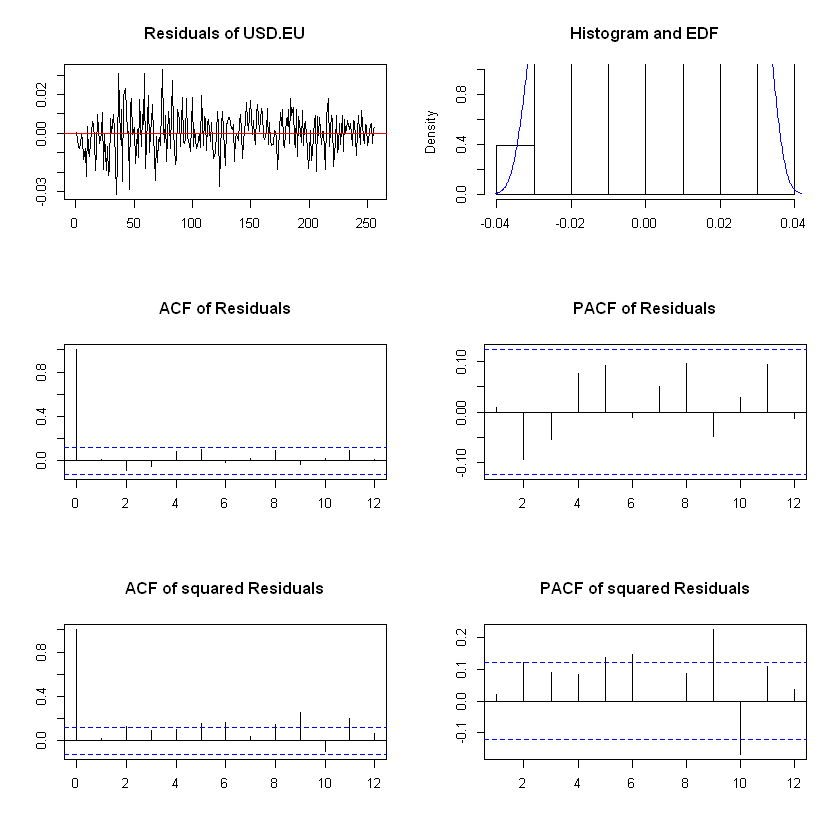

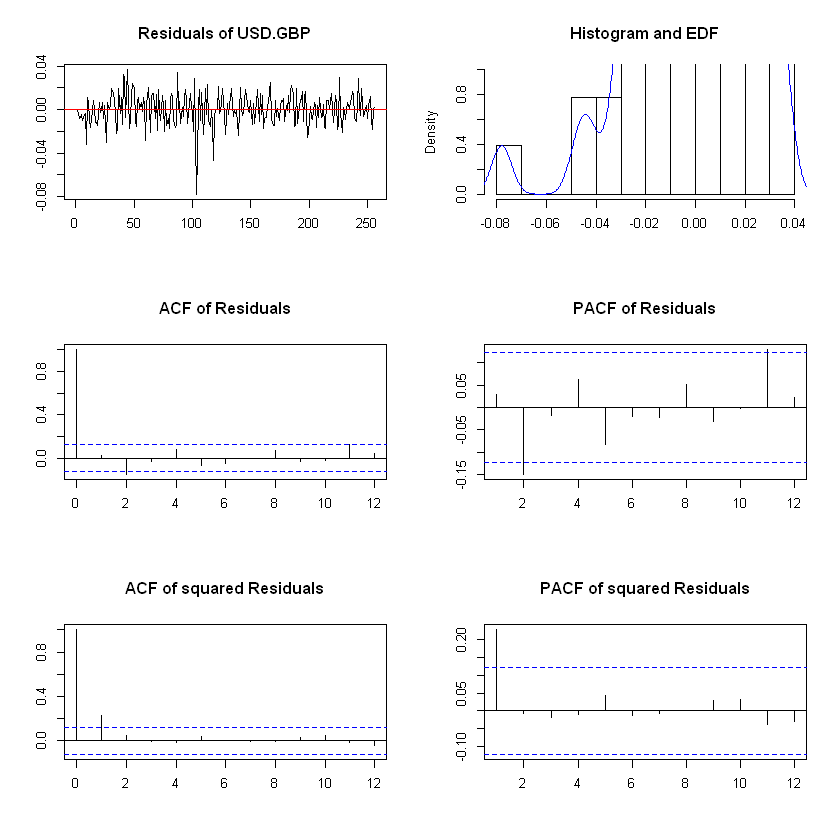

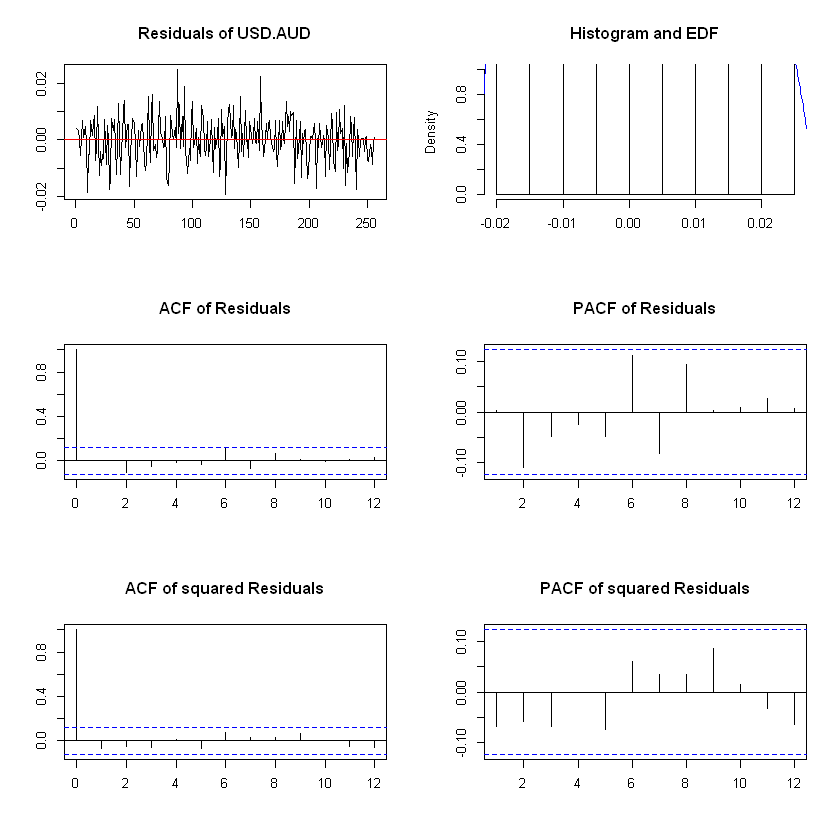

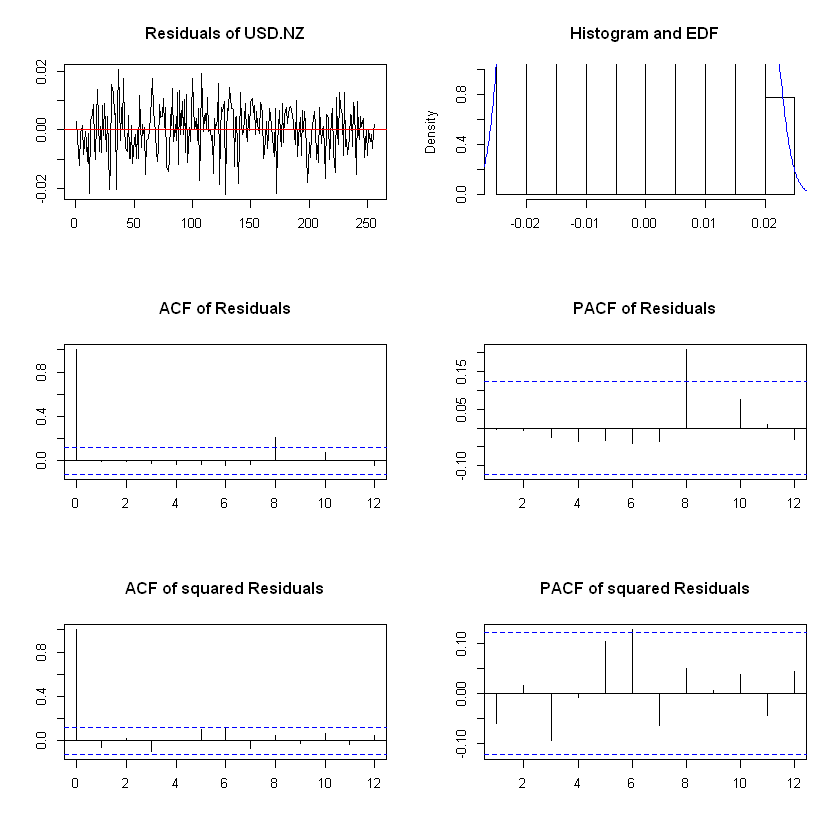

In [28]:
## Residual Analysis: Uncorrelated Errors Assumption: Portmonteau
serial.test(mod)
serialtest = serial.test(mod)
plot(serialtest)



In [29]:
## roots analysis: is this VAR process stable?
roots_mod = roots(mod)
sum(roots_mod>=1)

[1] 0

In [30]:
pred=predict(mod, n.ahead=8)
pred
pred[[1]]$USD.EU[,1]
pred[[1]]$USD.GBP[,1]
pred[[1]]$USD.AUD[,1]
pred[[1]]$USD.NZ[,1]

$USD.EU
         fcst    lower    upper         CI
[1,] 1.118771 1.097438 1.140103 0.02133203
[2,] 1.117654 1.085185 1.150123 0.03246897
[3,] 1.116491 1.075443 1.157539 0.04104760
[4,] 1.115348 1.067149 1.163548 0.04819962
[5,] 1.114239 1.059805 1.168673 0.05443391
[6,] 1.113164 1.053142 1.173187 0.06002261
[7,] 1.112122 1.046994 1.177250 0.06512814
[8,] 1.111109 1.041254 1.180965 0.06985550

$USD.GBP
         fcst    lower    upper         CI
[1,] 1.262675 1.234231 1.291119 0.02844404
[2,] 1.260379 1.216346 1.304413 0.04403367
[3,] 1.258171 1.202498 1.313844 0.05567331
[4,] 1.256105 1.191026 1.321184 0.06507878
[5,] 1.254182 1.181105 1.327259 0.07307676
[6,] 1.252392 1.172290 1.332493 0.08010151
[7,] 1.250722 1.164318 1.337127 0.08640449
[8,] 1.249162 1.157018 1.341307 0.09214436

$USD.AUD
          fcst     lower     upper         CI
[1,] 0.6976406 0.6824305 0.7128507 0.01521012
[2,] 0.6995903 0.6759823 0.7231984 0.02360806
[3,] 0.7012592 0.6713868 0.7311316 0.02987242
[4,] 0.7027275

[1] 1.118771 1.117654 1.116491 1.115348 1.114239 1.113164 1.112122 1.111109

[1] 1.262675 1.260379 1.258171 1.256105 1.254182 1.252392 1.250722 1.249162

[1] 0.6976406 0.6995903 0.7012592 0.7027275 0.7040261 0.7051736 0.7061849
[8] 0.7070730

[1] 0.6579957 0.6590455 0.6599535 0.6607551 0.6614599 0.6620758 0.6626104
[8] 0.6630706

[1] 1.118771 1.117654 1.116491 1.115348 1.114239 1.113164 1.112122 1.111109

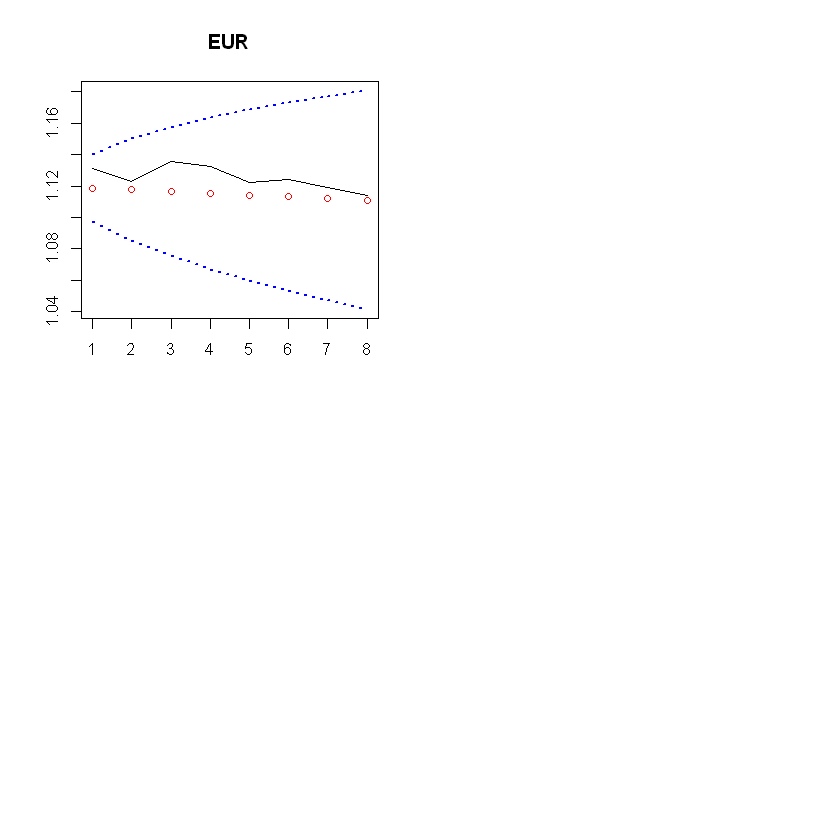

In [31]:
pred[[1]]$USD.EU[,1]

ubound = pred[[1]]$USD.EU[,2]
lbound = pred[[1]]$USD.EU[,3]

ymin = min(c(ubound,lbound,pred[[1]]$USD.EU[,1]))
ymax = max(c(ubound,lbound,pred[[1]]$USD.EU[,1]))


par(mfrow=c(2,2))


par(mfrow=c(2,2))
plot(1:8, test[,2], type="l", ylim=c(ymin,ymax), xlab="", ylab="", main="EUR") 
points(1:8,pred[[1]]$USD.EU[,1],col="red") 
lines(1:8, ubound,lty=3,lwd= 2, col="blue")
lines(1:8, lbound,lty=3,lwd= 2, col="blue")

[1] 1.262675 1.260379 1.258171 1.256105 1.254182 1.252392 1.250722 1.249162

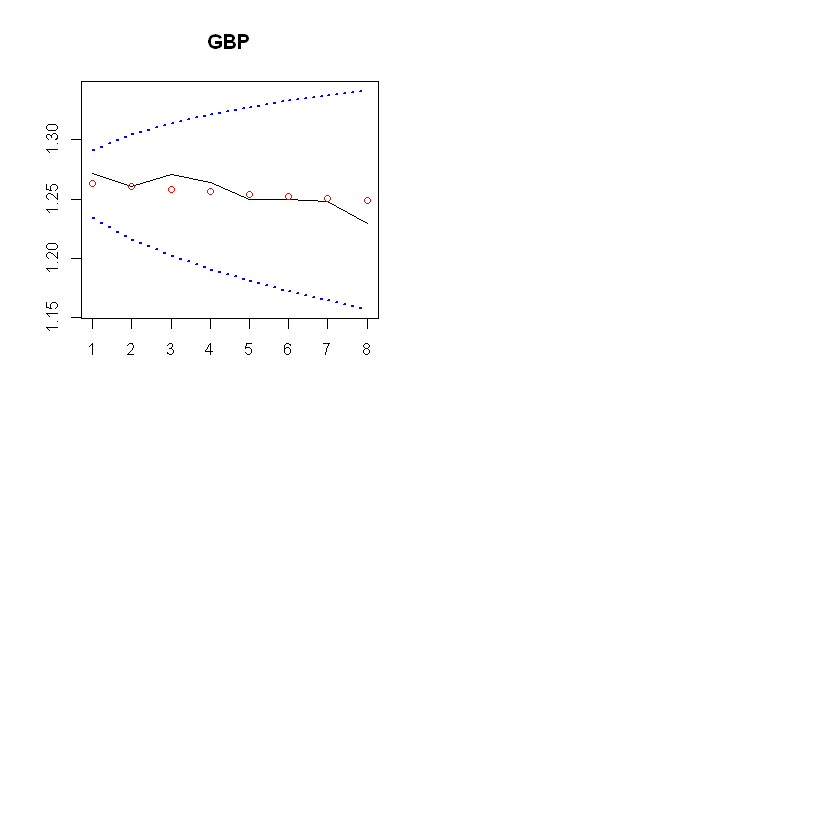

In [32]:
pred[[1]]$USD.GBP[,1]

ubound = pred[[1]]$USD.GBP[,2]
lbound = pred[[1]]$USD.GBP[,3]

ymin = min(c(ubound,lbound,pred[[1]]$USD.GBP[,1]))
ymax = max(c(ubound,lbound,pred[[1]]$USD.GBP[,1]))


par(mfrow=c(2,2))
a=nrow(data)-9
b=nrow(data)

par(mfrow=c(2,2))
plot(1:8, test[,3], type="l", ylim=c(ymin,ymax), xlab="", ylab="", main="GBP") 
points(1:8,pred[[1]]$USD.GBP[,1],col="red") 
lines(1:8, ubound,lty=3,lwd= 2, col="blue")
lines(1:8, lbound,lty=3,lwd= 2, col="blue")

[1] 0.6976406 0.6995903 0.7012592 0.7027275 0.7040261 0.7051736 0.7061849
[8] 0.7070730

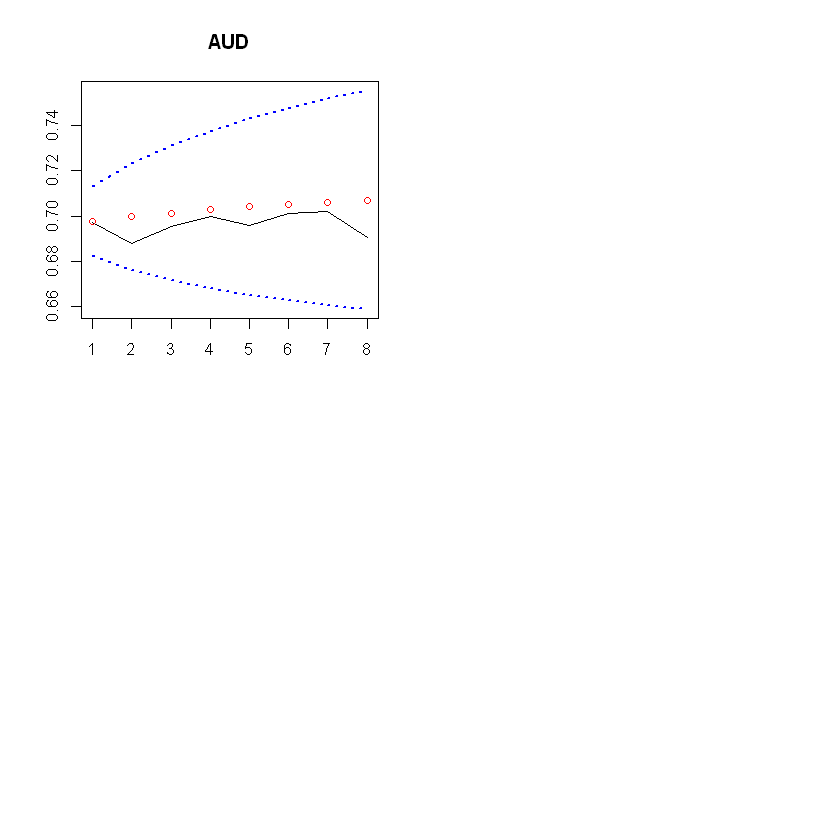

In [33]:
pred[[1]]$USD.AUD[,1]

ubound = pred[[1]]$USD.AUD[,2]
lbound = pred[[1]]$USD.AUD[,3]

ymin = min(c(ubound,lbound,pred[[1]]$USD.AUD[,1]))
ymax = max(c(ubound,lbound,pred[[1]]$USD.AUD[,1]))


par(mfrow=c(2,2))
a=nrow(data)-9
b=nrow(data)

par(mfrow=c(2,2))
plot(1:8, test[,4], type="l", ylim=c(ymin,ymax), xlab="", ylab="", main="AUD") 
points(1:8,pred[[1]]$USD.AUD[,1],col="red") 
lines(1:8, ubound,lty=3,lwd= 2, col="blue")
lines(1:8, lbound,lty=3,lwd= 2, col="blue")

[1] 0.6579957 0.6590455 0.6599535 0.6607551 0.6614599 0.6620758 0.6626104
[8] 0.6630706

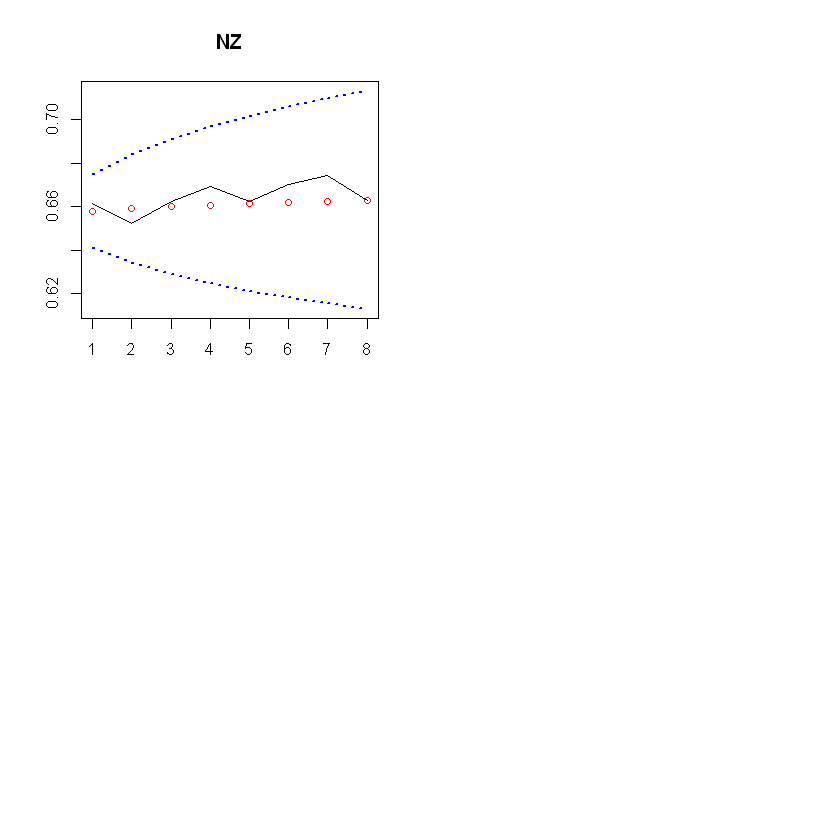

In [34]:
pred[[1]]$USD.NZ[,1]

ubound = pred[[1]]$USD.NZ[,2]
lbound = pred[[1]]$USD.NZ[,3]

ymin = min(c(ubound,lbound,pred[[1]]$USD.NZ[,1]))
ymax = max(c(ubound,lbound,pred[[1]]$USD.NZ[,1]))


par(mfrow=c(2,2))
a=nrow(data)-9
b=nrow(data)

par(mfrow=c(2,2))
plot(1:8,test[,5], type="l", ylim=c(ymin,ymax), xlab="", ylab="", main="NZ") 
points(1:8,pred[[1]]$USD.NZ[,1],col="red") 
lines(1:8, ubound,lty=3,lwd= 2, col="blue")
lines(1:8, lbound,lty=3,lwd= 2, col="blue")

In [35]:
obs1=test[,2]
MAPE1=mean(abs(pred[[1]]$USD.EU[,1]-obs1)/obs1)*100
MAPE1



obs2=test[,3]
MAPE2=mean(abs(pred[[1]]$USD.GBP[,1]-obs2)/obs2)*100
MAPE2


obs3=test[,4]
MAPE3=mean(abs(pred[[1]]$USD.AUD[,1]-obs3)/obs3)*100
MAPE3


obs4=test[,5]
MAPE4=mean(abs(pred[[1]]$USD.NZ[,1]-obs4)/obs4)*100 
MAPE4


[1] 0.9192391

[1] 0.588012

[1] 0.9759582

[1] 0.8015219